https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html

In [1]:
# Firstly, some necessary imports
%matplotlib inline 

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
# from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
# import matplotlib as mpl
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# from matplotlib.colors import ListedColormap, BoundaryNorm
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, ExportToTiff
from eolearn.mask import AddMultiCloudMaskTask, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection

C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\eolearn\io\processing_api.py:176: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ProcApiType("bool_mask", 'DN', 'UINT8', np.bool, FeatureType.MASK): [


C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dimension of the area is 2496630 x 2139124 m2


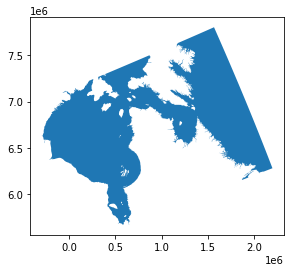

In [2]:
# Load shape file of the area of interest
ice_gdf = gpd.read_file('data/cis_SGRDRHB_20200525T1800Z_pl_a.shp')#load shape file inclusing sea ice concentration data
ice_gdf = ice_gdf.to_crs('EPSG:32617')

region = ice_gdf.dropna()#remove polygons where there is not data (corresponds to land)
region = region.geometry.unary_union#get the untion of all the water area
region = gpd.GeoDataFrame(geometry=[region], crs=ice_gdf.crs)

# region = region.buffer(500)

# Get the region shape in polygon format
region_shape = region.geometry.values[-1]

# Plot region
region.plot()

# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(region_shape.bounds[2] - region_shape.bounds[0],
                                                             region_shape.bounds[3] - region_shape.bounds[1]))

In [3]:
from sentinelhub import BBoxSplitter
# Create the splitter to obtain a list of bboxes
bbox_splitter = BBoxSplitter([region_shape], region.crs, (35, 35))

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())
for n, info in enumerate(info_list):
    info['index']=n

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info['index'] for info in info_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

gdf = gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y},
                           crs=region.crs,
                           geometry=geometry)

C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


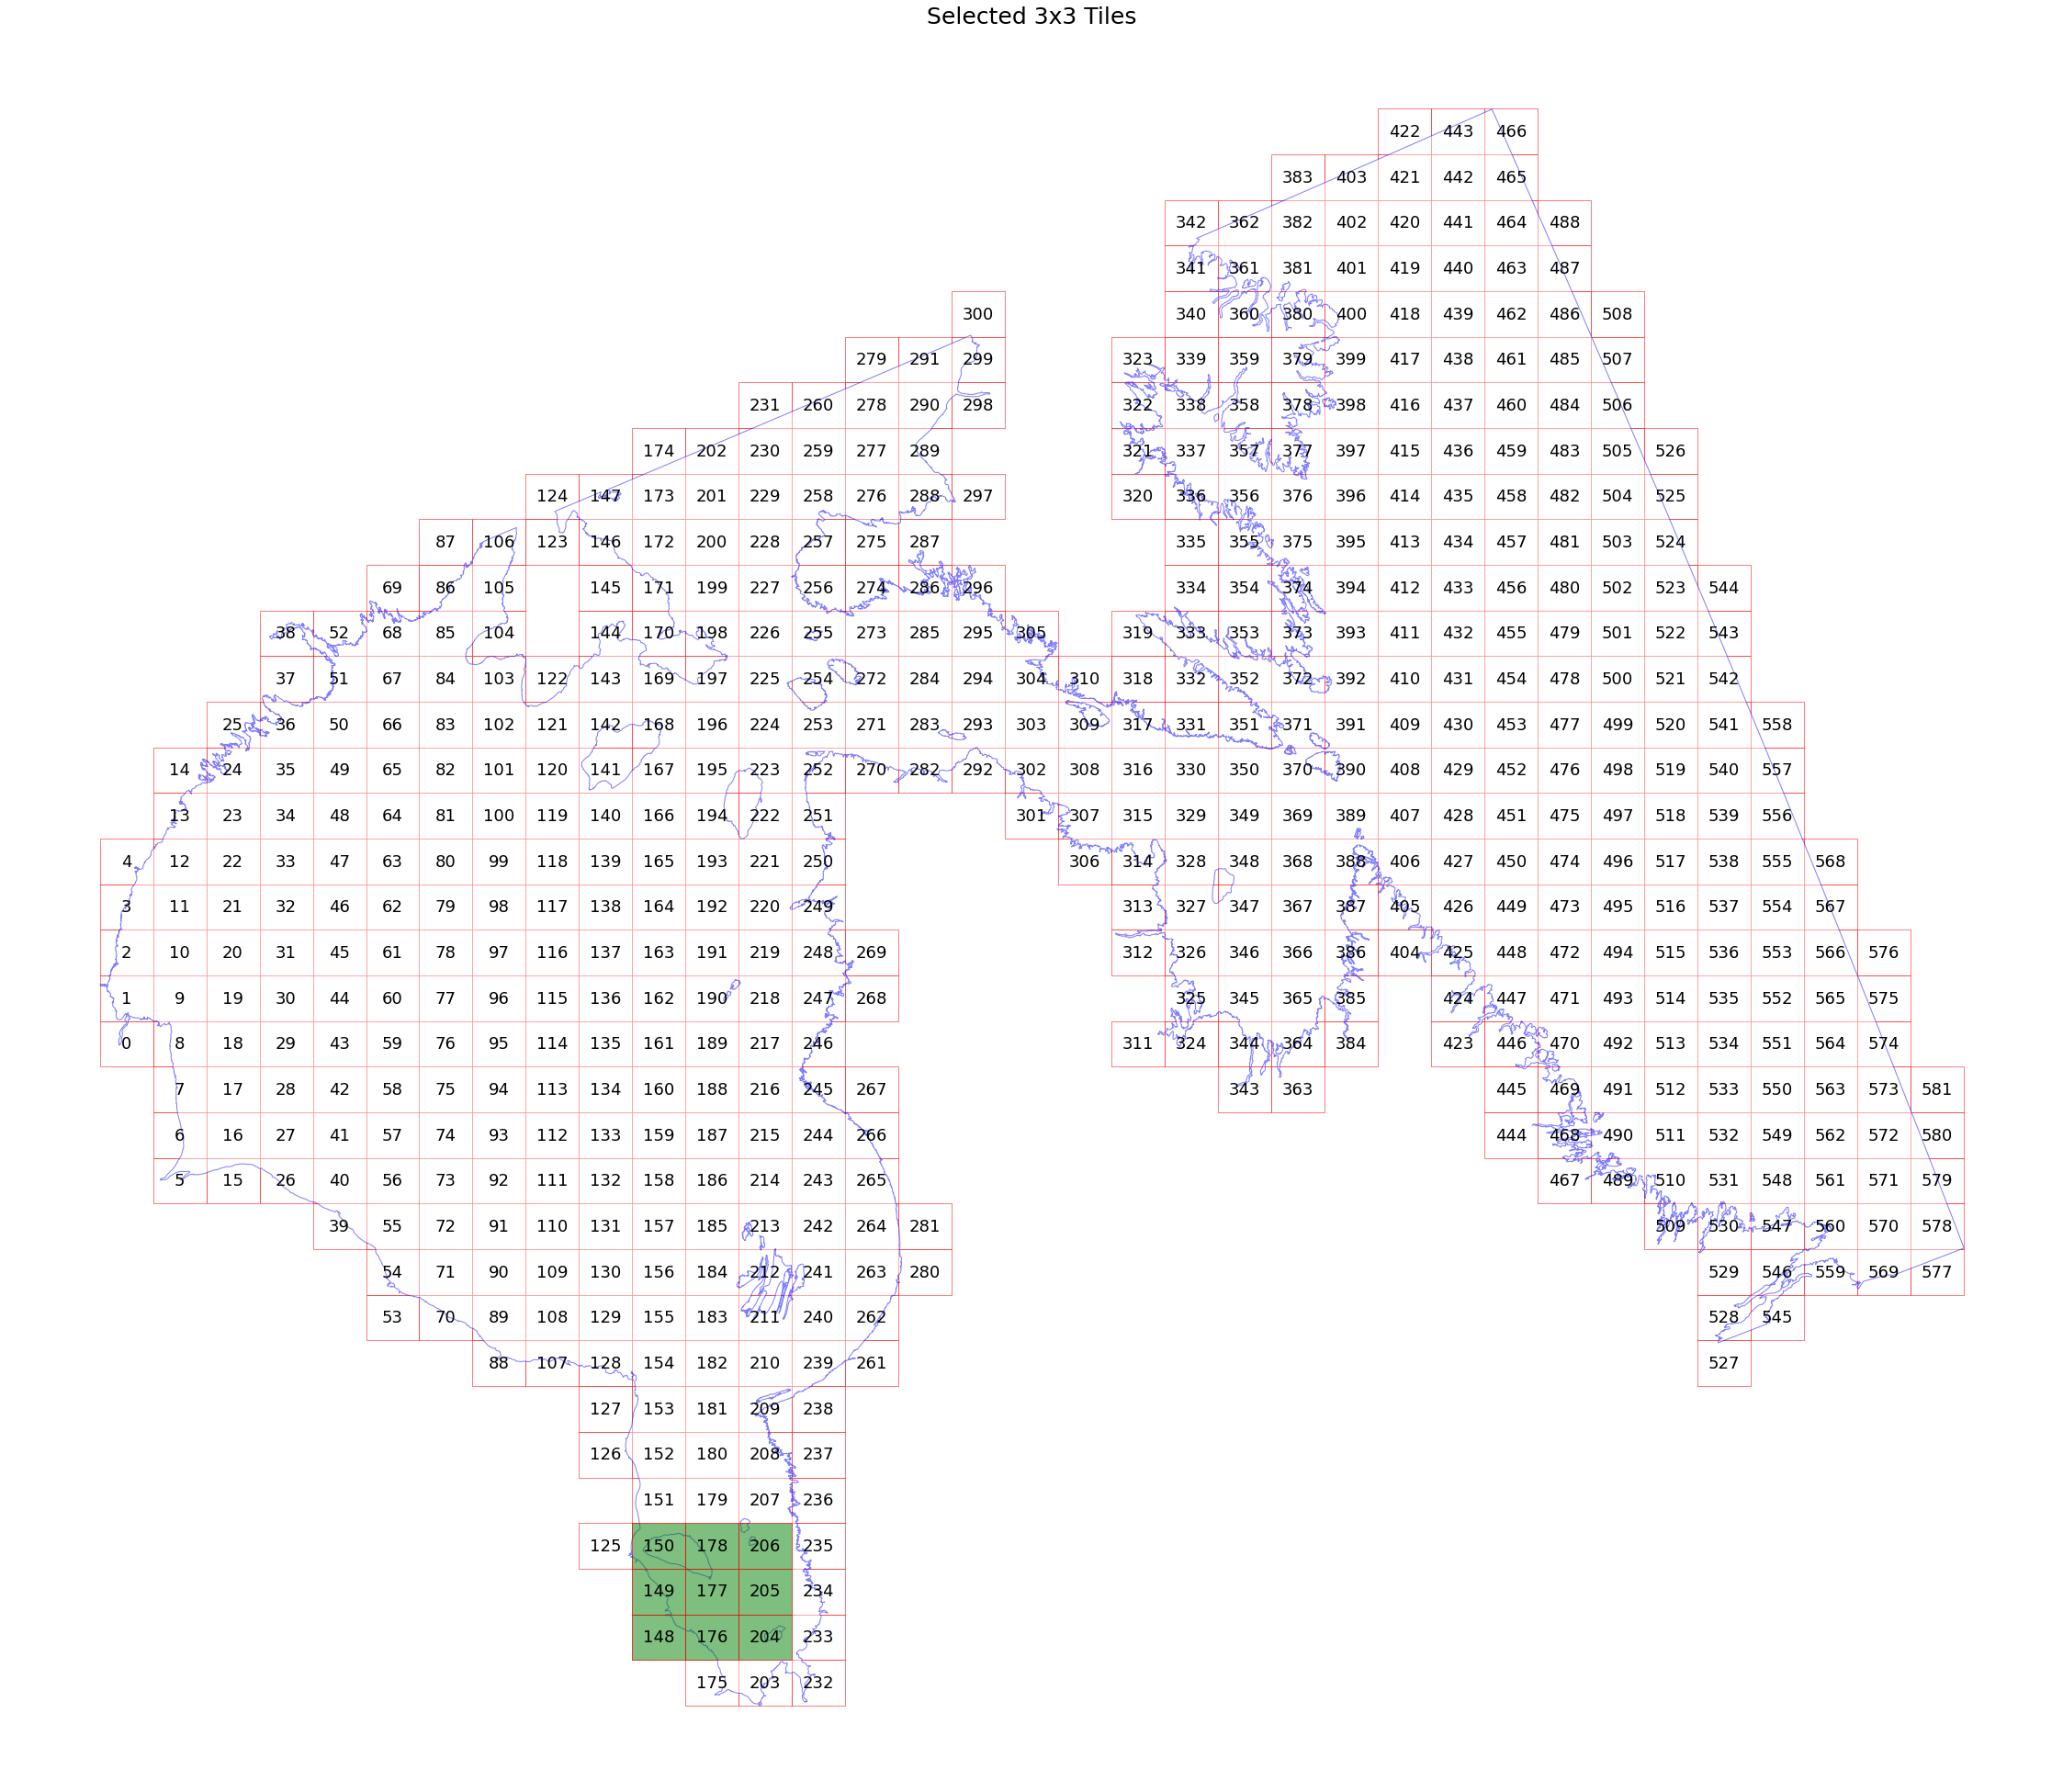

In [46]:
# select a 3x3 area (id of center patch)
ID = 177

# Obtain surrounding 3x3 patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 3*3:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()

# save to shapefile
shapefile_name = './grid_sea_ice.gpkg'
gdf.to_file(shapefile_name, driver='GPKG')

# figure
fig, ax = plt.subplots(figsize=(40, 40))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
region.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3 Tiles', fontsize=25);
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center', size=18)

gdf[gdf.index.isin(patchIDs)].plot(ax=ax,facecolor='g',edgecolor='r',alpha=0.5)

plt.axis('off');

In [5]:
#these classes are used toidentify and remove sections that are cloudy or have not data

class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch

C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#define the necessairy EOTasks which will be used in workflow do download satellite images and their corresponding sea ice masks
#task for downloading saetlite data
band_names = ['B03', 'B04', 'B08']#false color bands

#TASK TO RETRIEVE IMAGES FROM SENTINELHUB
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),#location where the images will be stored in the EOPatch
    bands = band_names,#bands to collect in the image
    resolution=200,#resolution of the images in m
    maxcc=0.8,#maximum cloud cover to allow 1=100%
    time_difference=datetime.timedelta(minutes=120),#if two images are this close to each other they are considered the same
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),#also download the 'is_data' and cloud cover masks from sentinelhub
                     (FeatureType.MASK, 'CLM'),]
)

#TASK TO ADD A MASK THAT COMBINES THE CLOUD COVER AND 'IS_DATA' MASKS INTO ONE 'VALID_DATA' MASK
def calculate_valid_data_mask(eopatch):
    is_data_mask = eopatch.mask['IS_DATA'].astype(bool)
    cloud_mask = ~eopatch.mask['CLM'].astype(bool)
    return np.logical_and(is_data_mask, cloud_mask)

add_valid_mask = AddValidDataMaskTask(predicate=calculate_valid_data_mask, valid_data_feature='VALID_DATA')

#funtction to calculate cloud coverage used in the next task
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

#CUSTOM EOTASK WHICH ADDS A SCALAR FEATURE WITH % OF IMAGE THAT IS VALID (AVAILABLE AND NOT CLOUDY)
class AddValidDataCoverage(EOTask):

    def execute(self, eopatch):

        valid_data = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA')
        time, height, width, channels = valid_data.shape

        coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))

        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch

add_coverage = AddValidDataCoverage()

#CUSTOM EOTASK WHICH REMOVES IMAGES IF THE date is more than one day away from a Monday
days = [6,0,1] #days of the week to include where 0 is monday and 6 is sunday

class ValidDatePredicate:
    
    def __init__(self, days):
        self.days = days

    def __call__(self, array):
        return array.weekday() in self.days

remove_dates = SimpleFilterTask((FeatureType.TIMESTAMP),
                                        ValidDatePredicate(days))


#CUSTOM EOTASK WHICH REMOVES IMAGES IF THE MORE THAN 'cloud_coverage_threshold' IS INVALID DATA
cloud_coverage_threshold = 0.10

class ValidDataCoveragePredicate:
    
    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        return calculate_coverage(array) < self.threshold

remove_cloudy_scenes = SimpleFilterTask((FeatureType.MASK, 'VALID_DATA'),
                                        ValidDataCoveragePredicate(cloud_coverage_threshold))

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [7]:
#CUSTOM TASK FOR ADDING A TIME-DEPENDENT ICE CHART MASK TO EACH IMAGE. THE ICE CHART IS THE WEEKLY REGIONAL SEA-ICE CHART PRODUCED
#BY THE CANADIAN GOVERNEMENT THAT IS CLOSEST TO THE DATE THE IMAGE WAS TAKEN

chart_dir = "./data/ice_charts/2019"
base_len=31 #the base length of the name of the folders and files(without the extension)

class TimeRaster(EOTask):
    
    def __init__(self, chart_dir, base_len):
        self.chart_dir = chart_dir
        self.base_len = base_len

    def execute(self, eopatch):
        
        chart_folders = [name for name in os.listdir(chart_dir)]#all the sea ice chart folders available
        chart_dates = np.array([datetime.datetime.strptime(name.split('_')[2][:8], '%Y%m%d') for name in os.listdir(chart_dir)])#all the dates available
        chart_dates = chart_dates+datetime.timedelta(hours=12)#add 12 hours to the date so it is in the middle of the day
        
        #get the ice chart dates corresponding to the image dates
        sat_dates = np.array(eopatch.timestamp)#get the dates for each image in the eopatch
        mask_dates=[]#this will hold the dates of the ice chart associated with each satellite image
        for date in sat_dates:
            closest_date_id = np.argsort(abs(date-chart_dates))[0]
            closest_date = chart_dates[closest_date_id]#closest ice chart date to the image date
            mask_dates.append(closest_date)
        
        #get the file paths of the ice charts corresponding to the images
        chart_paths = []
        for date in mask_dates:
            names = [name for name in chart_folders if date.strftime('%Y%m%d') in name]#get all the the folder names that match the date
            folder = max(names, key=len) #get the longest named folder (this is the most recent revision in case the folder was updated)
            if len(folder)>self.base_len:#if the folder has been updated
                file = folder[:self.base_len]#then the file will only contain the first base_len characters
            else: 
                file = folder#otherwise the filename is the same as the folder
            chart_paths.append(self.chart_dir+'/'+folder+'/'+file+'.shp')#file path of the ice chart shapefile
        
        #gather all of the ice charts into a single time-dependent feature
        times, length, width, channels = eopatch.data['BANDS'].shape
        timed_mask = np.zeros(shape=(times, length, width, 1), dtype=np.int16)
        for count, path in enumerate(chart_paths):#for each ice chart path
            chart = gpd.read_file(path)#get the ice chart
            chart.fillna(-1, inplace=True)#nans are land, we will fill them with -1
            chart['CT'] = chart['CT'].astype('int16')
            chart = chart.to_crs(region.crs)#make sure the chart is in the correct crs
            
            #convert the chart to a raster image and store in the eopatch
            add_raster = VectorToRaster(chart, (FeatureType.MASK_TIMELESS, 'TEMP'),
                                        values_column='CT', raster_shape=(FeatureType.DATA, 'BANDS'),
                                        raster_dtype=np.int16)
            add_raster(eopatch)
            timed_mask[count] = eopatch.mask_timeless['TEMP']#append the resulting raster image to our numpy array
            
        eopatch.mask['ICE_CHART'] = timed_mask#store the numpy array in the eopatch mask feature
        return eopatch

time_raster = TimeRaster(chart_dir, base_len)

C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


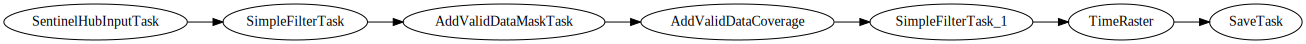

In [23]:
#generate eolearn workflow
workflow = LinearWorkflow(
    add_data,
    remove_dates,
    add_valid_mask,
    add_coverage, 
    remove_cloudy_scenes,
    time_raster,
    save,)
# Visualize workflow
workflow.dependency_graph()

In [47]:
%%time

# Execute the workflow
time_interval = ['2019-11-15', '2019-12-15'] # time interval for the SH request
# time_interval = ['2019-5-15', '2019-7-15'] # time interval for the SH request

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })
#     print(execution_args[0])

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run()

executor.make_report()

C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\eolearn\core\eodata.py:738: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not issubclass(value.dtype.type, (np.integer, np.bool, np.bool_, np.bool8)):
C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\eolearn\core\eodata.py:738: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not iss

Wall time: 1min 6s


In [48]:
for id in range(9):
    try:
        eopatch = EOPatch.load('./eopatches/eopatch_{}/'.format(id),  lazy_loading=True)
        print(id)
        print(eopatch.timestamp)
    except:
        pass

0
[datetime.datetime(2019, 12, 2, 16, 48, 26)]


C:\Users\DELL\anaconda3\envs\seaice10\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


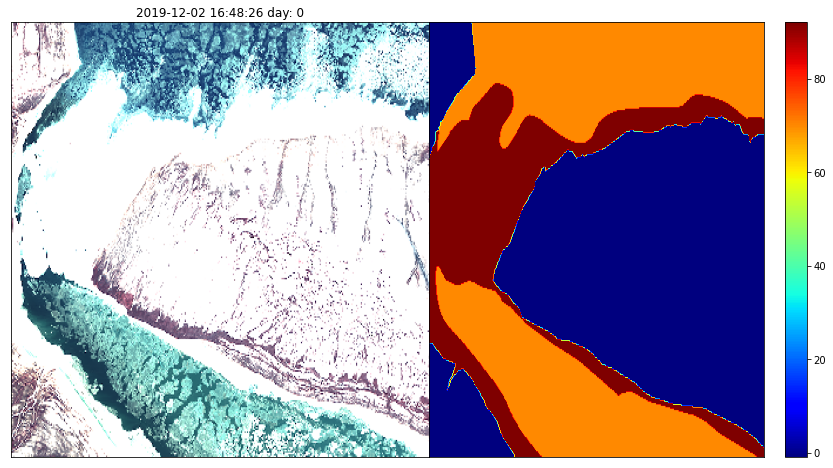

In [49]:
# Draw the RGB image

for n in range(9):
    try:
        eopatch = EOPatch.load('./eopatches/eopatch_{}/'.format(n),  lazy_loading=True)
        dates = np.array(eopatch.timestamp)
        # closest_date_id = np.argsort(abs(date-dates))[0]
        for date_id in range(len(eopatch.timestamp)):
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
            axs[0].imshow(np.clip(eopatch.data['BANDS'][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
            axs[0].set_xticks([])
            axs[0].set_yticks([])
            axs[0].set_aspect("auto")
            axs[0].set_title(str(eopatch.timestamp[date_id]) + ' day: ' + str(eopatch.timestamp[date_id].weekday()))
            im = axs[1].imshow(eopatch.mask['ICE_CHART'][closest_date_id], cmap='jet')
            fig.colorbar(im, ax=axs[1], orientation='vertical')
            axs[1].set_xticks([])
            axs[1].set_yticks([])
            axs[1].set_aspect("auto")
        del eopatch
    except:
        pass

fig.subplots_adjust(wspace=0, hspace=0)

(1900000.0, 2500000.0)

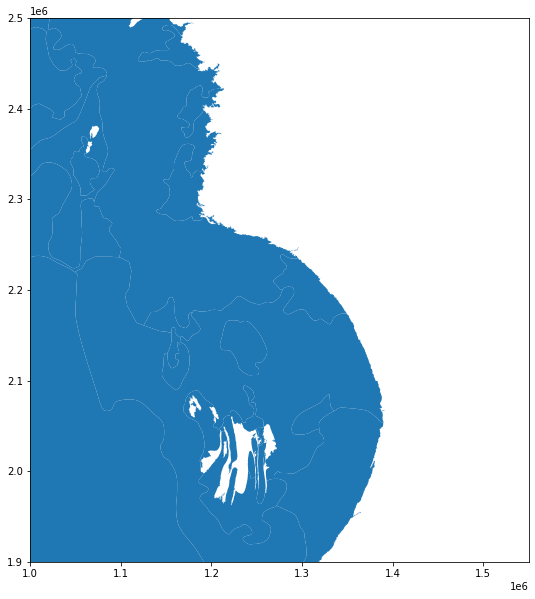

In [12]:
x = gpd.read_file('./data/ice_charts/2019/cis_SGRDRHB_20190624T1800Z_pl_a/cis_SGRDRHB_20190624T1800Z_pl_a.shp')
x.to_crs(region.crs)
fig, ax = plt.subplots(1, figsize=(10,10))
x.dropna().plot('POLY_TYPE', ax=ax)
ax.set_xlim(1e6, 1.55e6)
ax.set_ylim(1.9e6, 2.5e6)